In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import os

In [2]:
#Input_dim -> Hidden_dim -> mu, log_var -> reparametrization trick to sample z -> decoder -> output_dim
class VariationalAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=200, z_dim=100):
        super().__init__()

        #encoder
        self.img_to_hidden = nn.Linear(input_dim, hidden_dim)
        self.hidden_to_mu = nn.Linear(hidden_dim, z_dim)
        self.hidden_to_logvar = nn.Linear(hidden_dim, z_dim)

        #decoder
        self.z_to_hidden = nn.Linear(z_dim, hidden_dim)
        self.hidden_to_img = nn.Linear(hidden_dim, input_dim)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        #q_phi(z|x)
        h = self.relu(self.img_to_hidden(x))
        mu, logvar = self.hidden_to_mu(h), self.hidden_to_logvar(h)
        return mu, logvar

    def decode(self, z):
        #p_theta(x|z)
        h = self.relu(self.z_to_hidden(z))
        return self.sigmoid(self.hidden_to_img(h)) # Sử dụng sigmoid để output ảnh pixel từ 0-1

    def forward(self, x):
        mu, log_var = self.encode(x)
        # Reparameterization Trick: z = mu + sigma * epsilon
        # log_var -> var -> std_dev
        std = torch.exp(0.5 * log_var)
        epsilon = torch.randn_like(std) # Lấy mẫu từ phân phối Gaussian chuẩn
        z = mu + std * epsilon
        x_reconstructed = self.decode(z)
        return x_reconstructed, mu, log_var

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
INPUT_DIM = 784  # 28x28 pixels for MNIST
H_DIM = 200      # Kích thước lớp ẩn trong Encoder/Decoder
Z_DIM = 20       # Kích thước của không gian tiềm ẩn (latent space)
NUM_EPOCHS = 20  # Số lượng epoch huấn luyện
BATCH_SIZE = 64  # Kích thước batch
LR = 1e-3        # Tốc độ học (Learning rate)

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(), # Chuyển ảnh thành Tensor (giá trị 0-1)
    transforms.Lambda(lambda x: x.view(-1)) # Làm phẳng ảnh 28x28 thành vector 784
])

In [5]:
dataset = datasets.MNIST(root="dataset/", train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.48MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 160kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.16MB/s]


In [6]:
model = VariationalAutoencoder(input_dim=INPUT_DIM, hidden_dim=H_DIM, z_dim=Z_DIM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)

In [7]:
def vae_loss(x_reconstructed, x, mu, log_var):
    # Reconstruction Loss (Binary Cross-Entropy Loss)
    reconstruction_loss = nn.functional.binary_cross_entropy(x_reconstructed, x, reduction='sum')

    # KL Divergence Loss: -0.5 * sum(1 + log_var - mu^2 - exp(log_var))
    # Note: sum over latent dimensions, mean over batch
    kl_divergence_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    # Total VAE Loss (chúng ta đang tối thiểu hóa -ELBO)
    # Tối đa hóa ELBO tương đương với tối thiểu hóa (-ELBO)
    # chúng ta cộng Reconstruction Loss (để tái tạo tốt ảnh) và KL Divergence Loss (để buộc q(z|x) gần p(z)), trên thực tế q(z|x) sẽ không phải pp chuẩn tắc
    # như p(z)
    return reconstruction_loss + kl_divergence_loss

In [8]:
model.train()
for epoch in range(NUM_EPOCHS):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(DEVICE)

        # Forward pass
        x_reconstructed, mu, log_var = model(x)

        # Tính Loss
        loss = vae_loss(x_reconstructed, x, mu, log_var)

        # Backward pass và tối ưu hóa
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        overall_loss += loss.item()

    avg_loss = overall_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {avg_loss:.4f}")

Epoch [1/20], Loss: 160.2507
Epoch [2/20], Loss: 122.0801
Epoch [3/20], Loss: 115.6602
Epoch [4/20], Loss: 112.9398
Epoch [5/20], Loss: 111.3008
Epoch [6/20], Loss: 110.2577
Epoch [7/20], Loss: 109.5158
Epoch [8/20], Loss: 108.9834
Epoch [9/20], Loss: 108.4845
Epoch [10/20], Loss: 108.1085
Epoch [11/20], Loss: 107.7437
Epoch [12/20], Loss: 107.4975
Epoch [13/20], Loss: 107.2555
Epoch [14/20], Loss: 107.0172
Epoch [15/20], Loss: 106.8595
Epoch [16/20], Loss: 106.6711
Epoch [17/20], Loss: 106.4875
Epoch [18/20], Loss: 106.3385
Epoch [19/20], Loss: 106.2220
Epoch [20/20], Loss: 106.0617


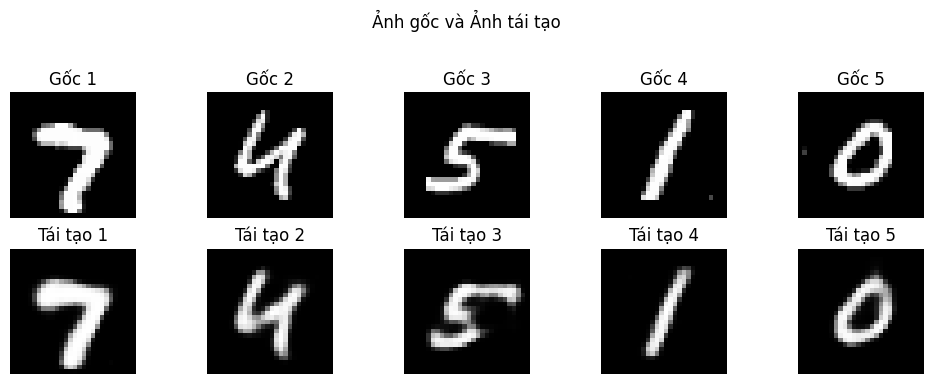

In [10]:
model.eval()
with torch.no_grad():
    data_iter = iter(train_loader)
    images, _ = next(data_iter)
    images = images.to(DEVICE)
    reconstructed_images, _, _ = model(images)

    # Hiển thị ảnh gốc và ảnh tái tạo
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i in range(5):
        # Ảnh gốc
        axes[0, i].imshow(images[i].cpu().view(28, 28), cmap='gray')
        axes[0, i].set_title(f"Gốc {i+1}")
        axes[0, i].axis('off')

        # Ảnh tái tạo
        axes[1, i].imshow(reconstructed_images[i].cpu().view(28, 28), cmap='gray')
        axes[1, i].set_title(f"Tái tạo {i+1}")
        axes[1, i].axis('off')
    plt.suptitle("Ảnh gốc và Ảnh tái tạo")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

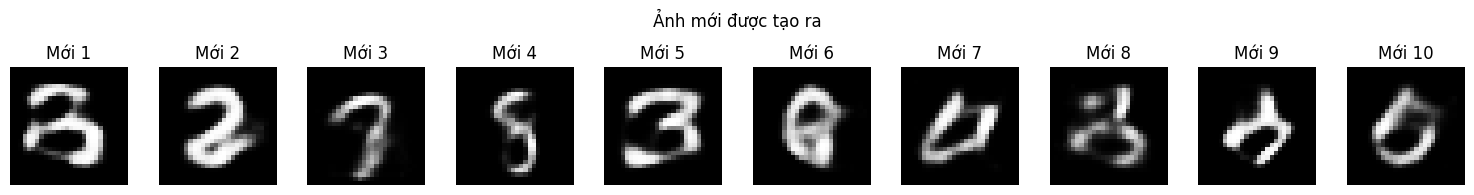

In [11]:
model.eval()
with torch.no_grad():
    z = torch.randn(10, Z_DIM).to(DEVICE)
    new_generated_images = model.decode(z).view(-1, 1, 28, 28)

    fig, axes = plt.subplots(1, 10, figsize=(15, 2))
    for i in range(10):
        axes[i].imshow(new_generated_images[i].cpu().view(28, 28), cmap='gray')
        axes[i].set_title(f"Mới {i+1}")
        axes[i].axis('off')
    plt.suptitle("Ảnh mới được tạo ra")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()